In [1]:
import os


# Environment configuration for a clean Jupyter environment with minimal logs and GPU setup.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "3"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_TRT_ALLOW_ENGINE_NATIVE_SEGMENT_EXECUTION"] = "false"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GRPC_CPP_LOG_LEVEL"] = "ERROR"

# Set visible GPU devices before importing TensorFlow
USE_ONLY_GPU_INDEX = 0
from tensorflow.python.framework import config as tf_config

physical_devices = tf_config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf_config.set_visible_devices(physical_devices[USE_ONLY_GPU_INDEX], 'GPU')
        tf_config.set_memory_growth(physical_devices[USE_ONLY_GPU_INDEX], True)
    except RuntimeError as e:
        print("GPU config error:", e)
else:
    raise RuntimeError("No GPU found!")

# Import TensorFlow and silence warnings
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

print("GPUs available:", tf.config.list_logical_devices('GPU'))


GPUs available: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [2]:
pip install backtesting

Looking in indexes: https://pypi.netflix.net/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load, dump

from backtesting import Backtest, Strategy
from bokeh.io import show, output_notebook, save

from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import (Input, MultiHeadAttention, Dropout, LayerNormalization,
                                     GlobalAveragePooling1D, Dense, Conv1D, MaxPooling1D,
                                     Flatten, GRU, SimpleRNN)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


Loading BokehJS ...

## Data

In [4]:
# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for processed data
# btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
# eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
# combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
# NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# File paths for data with features
btc_features_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.csv.gz")
eth_features_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.csv.gz")

# File paths for targets
btc_target_file = os.path.join(PROCESSED_DATA, "btc_1min_targets.csv.gz")
eth_target_file = os.path.join(PROCESSED_DATA, "eth_1min_targets.csv.gz")

# Load processed data
# btc_df = pd.read_csv(btc_processed_file, compression="gzip")
# eth_df = pd.read_csv(eth_processed_file, compression="gzip")
# crypto_df = pd.read_csv(combined_file, compression="gzip")
# df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

# Load feature data
btc_df_features = pd.read_csv(btc_features_file, compression="gzip")
eth_df_features = pd.read_csv(eth_features_file, compression="gzip")

# Load target data
btc_targets = pd.read_csv(btc_target_file, compression="gzip")
eth_targets = pd.read_csv(eth_target_file, compression="gzip")


## Constants & Functions

In [5]:
# File paths for saving results
RESULT_DATA_DIR = os.path.join("data", "result-data")
os.makedirs(RESULT_DATA_DIR, exist_ok=True)

In [6]:
# %%
# Utility: Create directories
def setup_directories():
    os.makedirs("plots", exist_ok=True)
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    return "Done"

# %%
# Prepares merged dataset of features + targets and subsets by percentage
def get_data_subset(features_df, targets_df, target_col, data_percent=0.01):
    merged = pd.concat([features_df, targets_df], axis=1)
    subset_size = int(len(merged) * data_percent)
    subset = merged.iloc[:subset_size].copy()
    X = subset.drop(columns=[target_col])
    y = subset[target_col]
    return X, y, subset

# %%
# Normalize features using MinMaxScaler
def scale_features(X):
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# %%
# Convert time-series data into sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# %%
# Time-based train/test split
def train_test_split_sequences(X_seq, y_seq, train_ratio=0.8):
    train_size = int(len(X_seq) * train_ratio)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]
    return X_train, y_train, X_test, y_test

# %%
# Build GRU model (easily replaceable with CNN/Transformer later)
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def format_percent_string(p):
    return f"{p * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")


# %%
# Train model with checkpointing and logging
def train_model(model, X_train, y_train, X_val, y_val, data_percent=0.01, epochs=20):
    
    percent_display = format_percent_string(data_percent)

    model_name = f"gru_btc_model_{percent_display}pct.h5"
    log_name = f"gru_btc_log_{percent_display}pct.csv"

    checkpoint = ModelCheckpoint(os.path.join("models", model_name), monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    csv_logger = CSVLogger(os.path.join("logs", log_name))

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stop, csv_logger],
        verbose=1
    )
    return history


# %%
# Evaluate performance
def print_metrics(y_test, y_pred, data_percent=0.01):
    

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Metrics for {data_percent*100:.3f}% dataset:")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")


In [7]:
def plot_loss(history, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc"):


    # Ensure directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent)  # for file name
    percent_display_title = f"{data_percent * 100:.2f}"            # for title

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve ({percent_display_title}% Data)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # Save to file inside plots directory
    filename = f"loss_curve_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    loss_curve_path = os.path.join(plots_dir, filename)
    plt.savefig(loss_curve_path)
    plt.show()
    print(f"Loss curve saved to: {loss_curve_path}")


In [8]:
def plot_predictions(y_test, y_pred, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc", last_n=200):


    # Ensure plots directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent)  # for file name
    percent_display_title = f"{data_percent * 100:.2f}"            # for plot title

    # Build comparison DataFrame
    comparison_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred.flatten()
    })

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(comparison_df["Actual"][-last_n:], label="Actual")
    plt.plot(comparison_df["Predicted"][-last_n:], label="Predicted", linestyle="--")
    plt.title(f"{dataset_name.upper()} Close Price Prediction (Last {last_n} Samples) - {percent_display_title}% Data")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"prediction_plot_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    plot_path = os.path.join(plots_dir, filename)
    plt.savefig(plot_path)
    print(f"Prediction plot saved to: {plot_path}")
    plt.show()

    # Save DataFrame comparison to CSV
    result_file = os.path.join(RESULT_DATA_DIR, f"{dataset_name}_comparison_{percent_display_filename}pct.csv")
    comparison_df.to_csv(result_file, index=False)

    print(f"Comparison CSV saved to: {result_file}")
    return comparison_df


In [9]:
def save_model_and_scaler(model, scaler, model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    os.makedirs("models", exist_ok=True)

    # Format percent with up to 4 decimal places, replace dot with underscore
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"scaler_{dataset_name}_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        save_model(model, str(model_path))
    else:
        dump(model, model_path)

    dump(scaler, scaler_path)

    print("Model saved to:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler saved to:", scaler_path.resolve().relative_to(Path.cwd()))


In [10]:
def load_model_and_scaler(model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    # Format percent with full decimals and replace '.' with '_'
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"scaler_{dataset_name}_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        model = load_model(model_path)
    else:
        model = load(model_path)

    scaler = load(scaler_path)

    print("Model loaded from:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler loaded from:", scaler_path.resolve().relative_to(Path.cwd()))

    return model, scaler

In [11]:
output_notebook()

def prepare_backtest_data(y_test, y_pred, time_index):
    df = pd.DataFrame({
        "Open": np.array(y_test).flatten(),
        "High": np.array(y_test).flatten(),
        "Low": np.array(y_test).flatten(),
        "Close": np.array(y_test).flatten(),
        "Signal": np.where(np.array(y_pred).flatten() > np.array(y_test).flatten(), 1, -1)
    })
    df.index = time_index
    return df

class MLStrategy(Strategy):
    def init(self):
        self.signal = self.data.Signal
    def next(self):
        if self.signal[-1] == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif self.signal[-1] == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()

def run_backtest(y_test, y_pred, initial_cash=100, model_name="gru", dataset_name="btc", data_percent=0.01):
    time_index = y_test.index if hasattr(y_test, 'index') else pd.date_range(
        start='2022-01-01', periods=len(np.array(y_test).flatten()), freq='T')
    
    data = prepare_backtest_data(y_test, y_pred, time_index)
    bt = Backtest(data, MLStrategy, cash=initial_cash, commission=0.0, exclusive_orders=True)
    stats = bt.run()
    print(stats)
    
    # Create a results directory based on model info.
    percent_str = f"{data_percent*100:.4f}".rstrip("0").rstrip(".").replace(".", "_")
    result_dir = os.path.join("results", f"{model_name}_{dataset_name}_{percent_str}pct")
    os.makedirs(result_dir, exist_ok=True)
    
    # Save backtest statistics as CSV.
    csv_filename = os.path.join(result_dir, "backtest_result.csv")
    stats.to_csv(csv_filename)
    
    # Generate the plot, save it as HTML, and display it in Jupyter.
    plot_obj = bt.plot()
    html_filename = os.path.join(result_dir, "backtest_plot.html")
    save(plot_obj, filename=html_filename)    
    return stats


Loading BokehJS ...

## Initial Testing

In [21]:
# Variables for initial testing

DATA_PERCENT = 0.001
TIME_STEPS = 30
TARGET_COL = "btc_Close_1m_later"


In [5]:
setup_directories()

'Done'

In [8]:
X_raw, y_raw, btc_subset = get_data_subset(btc_df_features, btc_targets, TARGET_COL, DATA_PERCENT)


In [9]:
X_scaled, scaler = scale_features(X_raw)


In [10]:
X_seq, y_seq = create_sequences(X_scaled, y_raw.values, TIME_STEPS)

In [11]:
X_train, y_train, X_test, y_test = train_test_split_sequences(X_seq, y_seq)

In [12]:
model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [13]:
history = train_model(model, X_train, y_train, X_test, y_test, DATA_PERCENT)

Epoch 1/20
151/157 [===========================>..] - ETA: 0s - loss: 1.2512   
Epoch 1: val_loss improved from inf to 0.01225, saving model to models/gru_btc_model_0_1pct.h5
157/157 [==============================] - 4s 7ms/step - loss: 1.2152 - val_loss: 0.0123
Epoch 2/20
153/157 [============================>.] - ETA: 0s - loss: 0.1710
Epoch 2: val_loss improved from 0.01225 to 0.01056, saving model to models/gru_btc_model_0_1pct.h5
157/157 [==============================] - 1s 4ms/step - loss: 0.1703 - val_loss: 0.0106
Epoch 3/20
152/157 [============================>.] - ETA: 0s - loss: 0.1527
Epoch 3: val_loss improved from 0.01056 to 0.00613, saving model to models/gru_btc_model_0_1pct.h5
157/157 [==============================] - 1s 4ms/step - loss: 0.1516 - val_loss: 0.0061
Epoch 4/20
151/157 [===========================>..] - ETA: 0s - loss: 0.1406
Epoch 4: val_loss improved from 0.00613 to 0.00585, saving model to models/gru_btc_model_0_1pct.h5
157/157 [=====================

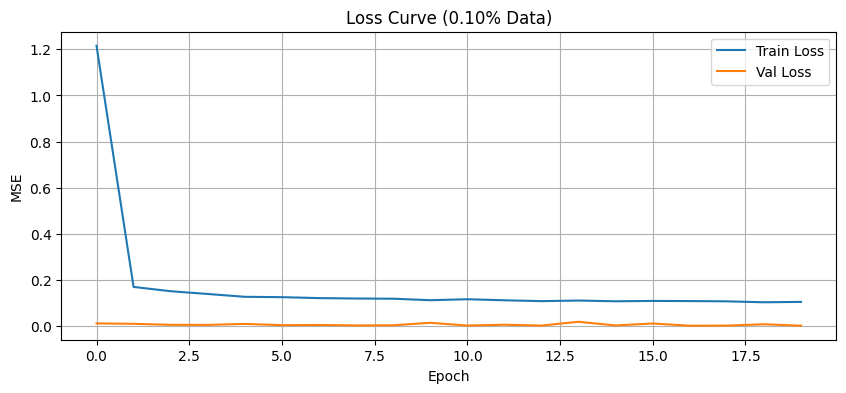

Loss curve saved to: plots/loss_curve_gru_btc_0_1pct.png


In [15]:
plot_loss(history, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")

In [16]:
y_pred = model.predict(X_test)

40/40 [==============================] - 0s 1ms/step


Prediction plot saved to: plots/prediction_plot_gru_btc_0_1pct.png


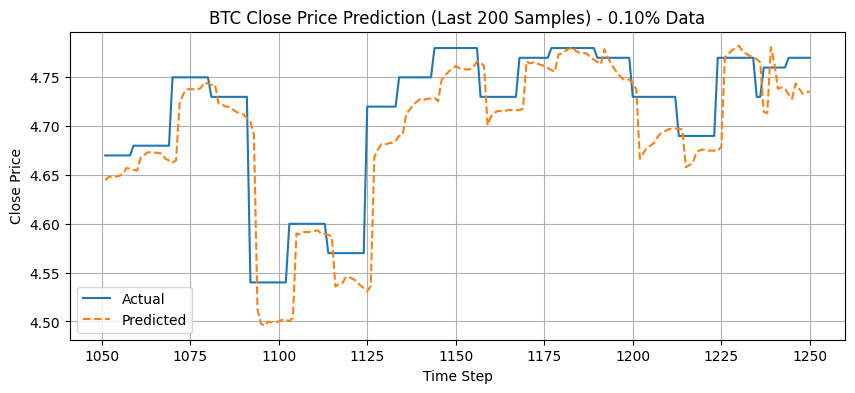

Comparison CSV saved to: data/result-data/btc_comparison_0_1pct.csv


In [18]:


comparison_df = plot_predictions(y_test, y_pred, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")


In [19]:
print_metrics(y_test, y_pred, DATA_PERCENT)

Metrics for 0.100% dataset:
MSE:  0.0023
RMSE: 0.0475
MAE:  0.0286


In [21]:
save_model_and_scaler(model, scaler, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model saved to: models/gru_btc_model_0_1pct.h5
Scaler saved to: models/scaler_btc_0_1pct.pkl


In [23]:
model, scaler = load_model_and_scaler(model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model loaded from: models/gru_btc_model_0_1pct.h5
Scaler loaded from: models/scaler_btc_0_1pct.pkl


In [35]:

# Example usage:
stats = run_backtest(y_test, y_pred, initial_cash=100, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)


Loading BokehJS ...

Backtest.run:   0%|          | 0/1250 [00:00<?, ?bar/s]

Start                     2022-01-01 00:00:00
End                       2022-01-01 20:50:00
Duration                      0 days 20:50:00
Exposure Time [%]                         0.0
Equity Final [$]                       110.98
Equity Peak [$]                        115.12
Return [%]                              10.98
Buy & Hold Return [%]               -11.33829
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
CAGR [%]                  1058035078373143...
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                              1.7785
Beta                                 -0.81154
Max. Drawdown [%]                     -5.9166
Avg. Drawdown [%]                    -2.58323
Max. Drawdown Duration        0 days 02:28:00
Avg. Drawdown Duration        0 days 00:49:00
# Trades                                    0
Win Rate [%]                      

## Using Funtions

In [14]:
def run_full_pipeline(asset, model_function, data_percent, epochs=20, time_steps=30, initial_cash=100):
    print(f"Loading data for asset: {asset}")
    if asset.lower() == "btc":
        features_df = btc_df_features
        targets_df = btc_targets
        target_col = "btc_Close_1m_later"
    elif asset.lower() == "eth":
        features_df = eth_df_features
        targets_df = eth_targets
        target_col = "eth_Close_1m_later"
    else:
        raise ValueError("Asset must be either 'btc' or 'eth'")
    
    print("Subsetting data...")
    X_raw, y_raw, _ = get_data_subset(features_df, targets_df, target_col, data_percent)
    
    print("Normalizing features...")
    X_scaled, scaler = scale_features(X_raw)
    
    print("Creating sequences...")
    X_seq, y_seq = create_sequences(X_scaled, y_raw.values, time_steps)
    
    print("Splitting data into training and testing sets...")
    X_train, y_train, X_test, y_test = train_test_split_sequences(X_seq, y_seq)
    
    print("Building model...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = model_function(input_shape)
    
    print("Training model...")
    history = train_model(model, X_train, y_train, X_test, y_test, data_percent, epochs)
    
    # Determine a model name for logging and saving
    model_name = model_function.__name__ if hasattr(model_function, '__name__') else "custom_model"
    
    print("Plotting training loss...")
    plot_loss(history, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Generating predictions...")
    y_pred = model.predict(X_test)
    
    print("Plotting predictions and saving comparison CSV...")
    comparison_df = plot_predictions(y_test, y_pred, data_percent=data_percent, model_name=model_name, dataset_name=asset)
    
    print("Printing evaluation metrics...")
    print_metrics(y_test, y_pred, data_percent)
    
    print("Saving model and scaler...")
    save_model_and_scaler(model, scaler, model_name=model_name, dataset_name=asset, data_percent=data_percent)
    
    print("Running backtesting...")
    stats = run_backtest(y_test, y_pred, initial_cash=initial_cash, model_name=model_name, dataset_name=asset, data_percent=data_percent)
    
    print("Pipeline complete.")
    return stats


Loading data for asset: btc
Subsetting data...
Normalizing features...
Creating sequences...
Splitting data into training and testing sets...
Building model...
Training model...
Epoch 1/20
78541/78543 [============================>.] - ETA: 0s - loss: 229370.2969      
Epoch 1: val_loss improved from inf to 31606324.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 252s 3ms/step - loss: 229366.3750 - val_loss: 31606324.0000
Epoch 2/20
78537/78543 [============================>.] - ETA: 0s - loss: 5454.9854   
Epoch 2: val_loss improved from 31606324.00000 to 24512400.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 244s 3ms/step - loss: 5454.7021 - val_loss: 24512400.0000
Epoch 3/20
78530/78543 [============================>.] - ETA: 0s - loss: 3869.9385  
Epoch 3: val_loss did not improve from 24512400.00000
78543/78543 [==============================] - 246s 3ms/step - loss: 3870.1040

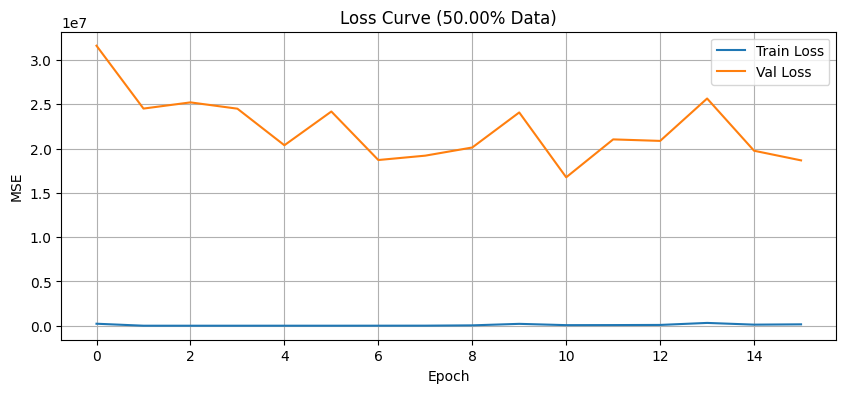

Loss curve saved to: plots/loss_curve_build_gru_model_btc_50pct.png
Generating predictions...
19636/19636 [==============================] - 26s 1ms/step
Plotting predictions and saving comparison CSV...
Prediction plot saved to: plots/prediction_plot_build_gru_model_btc_50pct.png


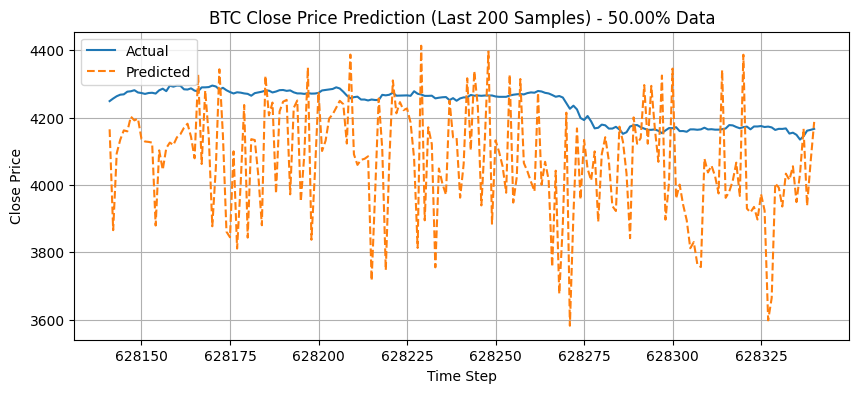

Comparison CSV saved to: data/result-data/btc_comparison_50pct.csv
Printing evaluation metrics...
Metrics for 50.000% dataset:
MSE:  16755720.9411
RMSE: 4093.3753
MAE:  3050.0819
Saving model and scaler...
Model saved to: models/build_gru_model_btc_model_50pct.h5
Scaler saved to: models/scaler_btc_50pct.pkl
Running backtesting...


Backtest.run:   0%|          | 0/628340 [00:00<?, ?bar/s]

Start                     2022-01-01 00:00:00
End                       2023-03-13 08:20:00
Duration                    436 days 08:20:00
Exposure Time [%]                         0.0
Equity Final [$]                        100.0
Equity Peak [$]                         100.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.12469
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

Pipeline complete.


In [14]:
stats_btc_gru = run_full_pipeline(asset="btc", model_function=build_gru_model, data_percent=.5)

## CNN

In [15]:
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

Loading data for asset: btc
Subsetting data...
Normalizing features...
Creating sequences...
Splitting data into training and testing sets...
Building model...
Training model...
Epoch 1/20
78543/78543 [==============================] - ETA: 0s - loss: 2664.5981        
Epoch 1: val_loss improved from inf to 7401.95898, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 182s 2ms/step - loss: 2664.5981 - val_loss: 7401.9590
Epoch 2/20
78537/78543 [============================>.] - ETA: 0s - loss: 773.6021   
Epoch 2: val_loss improved from 7401.95898 to 5169.53174, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 175s 2ms/step - loss: 773.5840 - val_loss: 5169.5317
Epoch 3/20
78521/78543 [============================>.] - ETA: 0s - loss: 733.7841  
Epoch 3: val_loss improved from 5169.53174 to 4475.63525, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 174s 2

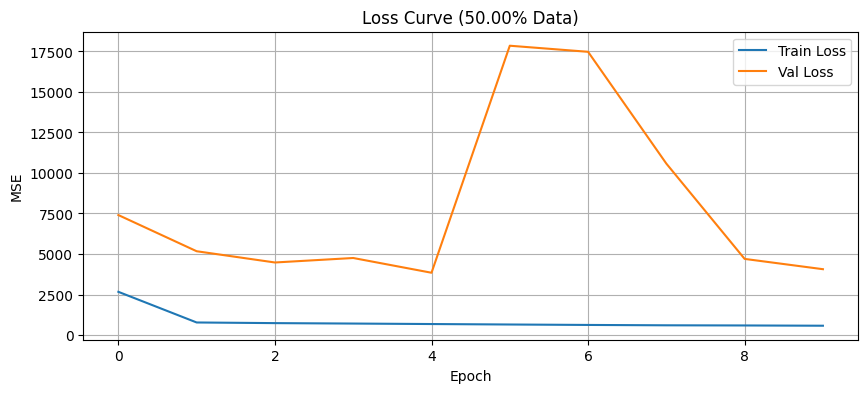

Loss curve saved to: plots/loss_curve_build_cnn_model_btc_50pct.png
Generating predictions...
19636/19636 [==============================] - 19s 905us/step
Plotting predictions and saving comparison CSV...
Prediction plot saved to: plots/prediction_plot_build_cnn_model_btc_50pct.png


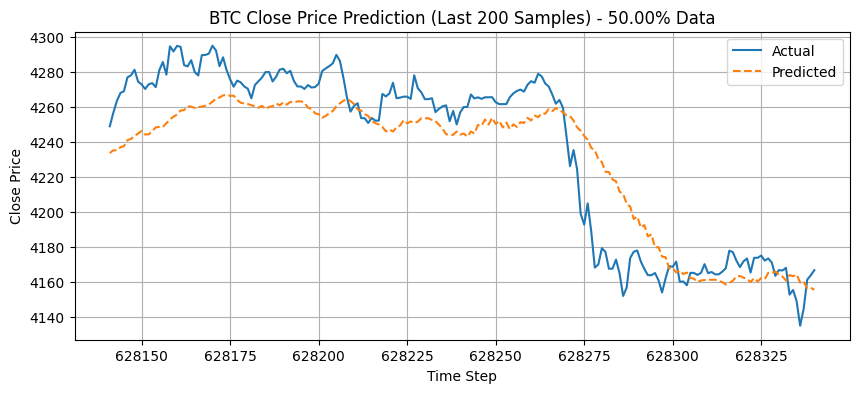

Comparison CSV saved to: data/result-data/btc_comparison_50pct.csv
Printing evaluation metrics...
Metrics for 50.000% dataset:
MSE:  3842.1779
RMSE: 61.9853
MAE:  36.3046
Saving model and scaler...
Model saved to: models/build_cnn_model_btc_model_50pct.h5
Scaler saved to: models/scaler_btc_50pct.pkl
Running backtesting...


Backtest.run:   0%|          | 0/628340 [00:00<?, ?bar/s]

Start                     2022-01-01 00:00:00
End                       2023-03-13 08:20:00
Duration                    436 days 08:20:00
Exposure Time [%]                         0.0
Equity Final [$]                        100.0
Equity Peak [$]                         100.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.12469
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

Pipeline complete.


In [16]:
stats_btc_cnn = run_full_pipeline(asset="btc", model_function=build_cnn_model, data_percent=0.5)

## Transformer

Loading data for asset: btc
Subsetting data...
Normalizing features...
Creating sequences...
Splitting data into training and testing sets...
Building model...
Building Transformer model with input shape: (30, 45)
Training model...
Epoch 1/20
78543/78543 [==============================] - ETA: 0s - loss: 5682.4058        
Epoch 1: val_loss improved from inf to 14460450.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 291s 4ms/step - loss: 5682.4058 - val_loss: 14460450.0000
Epoch 2/20
78542/78543 [============================>.] - ETA: 0s - loss: 209.4762  
Epoch 2: val_loss improved from 14460450.00000 to 13268569.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 291s 4ms/step - loss: 209.4808 - val_loss: 13268569.0000
Epoch 3/20
78541/78543 [============================>.] - ETA: 0s - loss: 161.0464  
Epoch 3: val_loss improved from 13268569.00000 to 12797834.00000, saving model to mo

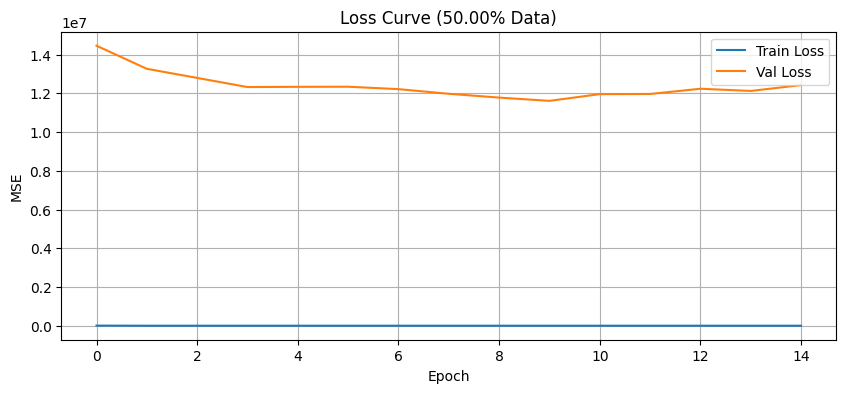

Loss curve saved to: plots/loss_curve_build_transformer_model_btc_50pct.png
Generating predictions...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [18]:
def build_transformer_model(input_shape):
    print("Building Transformer model with input shape:", input_shape)
    input_layer = Input(shape=input_shape)
    attention = MultiHeadAttention(num_heads=2, key_dim=input_shape[-1])(input_layer, input_layer)
    attention = Dropout(0.2)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + input_layer)
    pooled = GlobalAveragePooling1D()(attention)
    dense = Dense(64, activation='relu')(pooled)
    output = Dense(1, activation='linear')(dense)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

stats_btc_transformer = run_full_pipeline(asset="btc", model_function=build_transformer_model, 
                                          data_percent=0.5)

## RNN

In [12]:
def build_rnn_model(input_shape):
    print("Building RNN model with input shape:", input_shape)
    model = Sequential()
    model.add(SimpleRNN(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

Loading data for asset: btc
Subsetting data...
Normalizing features...
Creating sequences...
Splitting data into training and testing sets...
Building model...
Building RNN model with input shape: (30, 45)
Training model...
Epoch 1/20
78542/78543 [============================>.] - ETA: 0s - loss: 238623.4531       
Epoch 1: val_loss improved from inf to 29731644.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 938s 12ms/step - loss: 238621.9219 - val_loss: 29731644.0000
Epoch 2/20
78541/78543 [============================>.] - ETA: 0s - loss: 10124.0254   
Epoch 2: val_loss improved from 29731644.00000 to 22446392.00000, saving model to models/gru_btc_model_50pct.h5
78543/78543 [==============================] - 933s 12ms/step - loss: 10123.9893 - val_loss: 22446392.0000
Epoch 3/20
78542/78543 [============================>.] - ETA: 0s - loss: 8894.3701    
Epoch 3: val_loss did not improve from 22446392.00000
78543/78543 [============

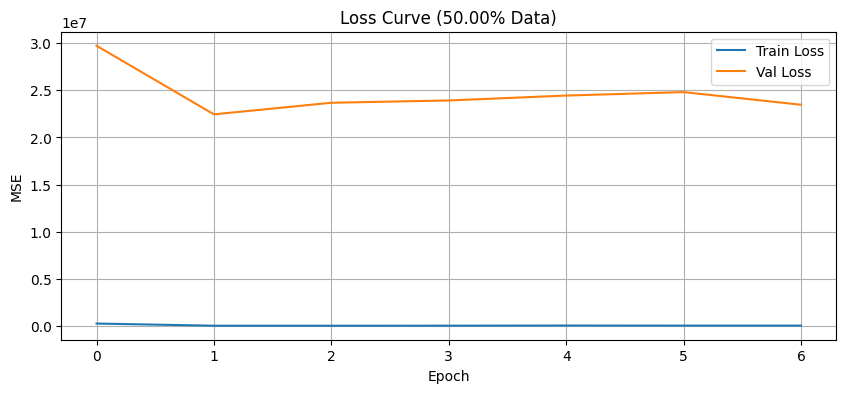

Loss curve saved to: plots/loss_curve_build_rnn_model_btc_50pct.png
Generating predictions...
19636/19636 [==============================] - 68s 3ms/step
Plotting predictions and saving comparison CSV...
Prediction plot saved to: plots/prediction_plot_build_rnn_model_btc_50pct.png


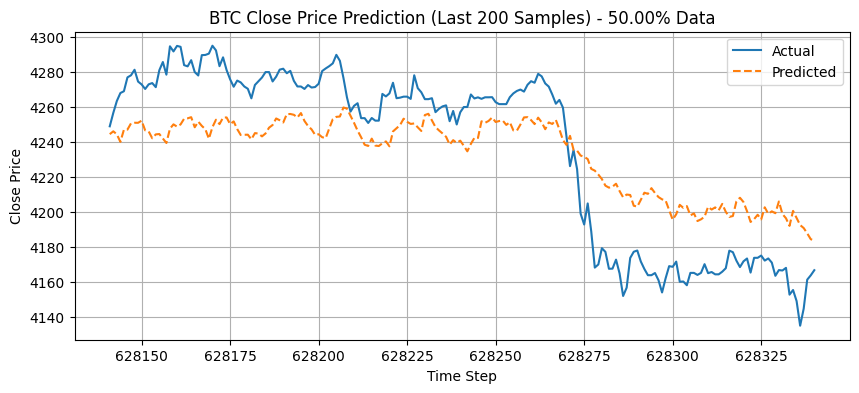

Comparison CSV saved to: data/result-data/btc_comparison_50pct.csv
Printing evaluation metrics...
Metrics for 50.000% dataset:
MSE:  22446451.7945
RMSE: 4737.7687
MAE:  3712.0216
Saving model and scaler...
Model saved to: models/build_rnn_model_btc_model_50pct.h5
Scaler saved to: models/scaler_btc_50pct.pkl
Running backtesting...


Backtest.run:   0%|          | 0/628340 [00:00<?, ?bar/s]

Start                     2022-01-01 00:00:00
End                       2023-03-13 08:20:00
Duration                    436 days 08:20:00
Exposure Time [%]                         0.0
Equity Final [$]                        100.0
Equity Peak [$]                         100.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.12469
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

Pipeline complete.


In [16]:
stats_btc_rnn = run_full_pipeline(asset="btc", model_function=build_rnn_model, data_percent=0.5)